In [2]:
import torch

def swap_top_two_softmax(tensor):
    # Find the top two values along the softmax dimension
    top2_values, top2_indices = torch.topk(tensor, 2, dim=1)
    
    # Clone the original tensor so we can modify it
    swapped_tensor = tensor.clone()
    
    # Create a tensor of batch indices
    batch_indices = torch.arange(tensor.size(0))
    
    # Get the indices of the top two values
    max_indices = top2_indices[:, 0]  # Highest value indices
    second_max_indices = top2_indices[:, 1]  # Second highest value indices
    
    # Swap the values by indexing per batch
    swapped_tensor[batch_indices, max_indices] = top2_values[:, 1]  # Place second highest value at highest index
    swapped_tensor[batch_indices, second_max_indices] = top2_values[:, 0]  # Place highest value at second highest index
    
    return swapped_tensor

# Example usage
tensor = torch.tensor([[0.1, 0.3, 0.4, 0.2],
                       [0.5, 0.2, 0.1, 0.2]])
swapped_tensor = swap_top_two_softmax(tensor)
print(swapped_tensor)

tensor([[0.1000, 0.4000, 0.3000, 0.2000],
        [0.2000, 0.5000, 0.1000, 0.2000]])


In [1]:
import torch

def shuffle_softmax(tensor):
    """
    Shuffles the values in the softmax dimension of the input tensor randomly.

    Args:
    tensor (torch.Tensor): A 2D tensor of shape (batch_size, softmax_dimension)

    Returns:
    torch.Tensor: A tensor with the same shape where values within each batch are shuffled randomly
    """
    # Get the batch size and softmax dimension from the tensor
    batch_size, softmax_dim = tensor.shape
    
    # Initialize an empty tensor to hold the shuffled values
    shuffled_tensor = torch.empty_like(tensor)
    
    # Iterate over each batch
    for i in range(batch_size):
        # Shuffle the values in the softmax dimension for this batch
        shuffled_tensor[i] = tensor[i, torch.randperm(softmax_dim)]
    
    return shuffled_tensor

# Example usage:
# Assuming you have a tensor of shape (batch_size, softmax_dimension)
batch_size = 4
softmax_dimension = 10
tensor = torch.rand(batch_size, softmax_dimension)

print("Original tensor:")
print(tensor)

shuffled_tensor = shuffle_softmax(tensor)

print("\nShuffled tensor:")
print(shuffled_tensor)


Original tensor:
tensor([[0.7667, 0.7316, 0.0411, 0.1111, 0.1016, 0.5771, 0.6889, 0.0186, 0.7981,
         0.0918],
        [0.0101, 0.2840, 0.6538, 0.1071, 0.0712, 0.8390, 0.8388, 0.1310, 0.1566,
         0.5162],
        [0.9439, 0.7272, 0.1107, 0.8281, 0.5282, 0.8070, 0.9990, 0.4912, 0.2826,
         0.2417],
        [0.7361, 0.0527, 0.4538, 0.4046, 0.9448, 0.6134, 0.1484, 0.1002, 0.3749,
         0.4899]])

Shuffled tensor:
tensor([[0.6889, 0.5771, 0.7981, 0.0411, 0.7667, 0.1111, 0.7316, 0.0918, 0.0186,
         0.1016],
        [0.8388, 0.6538, 0.5162, 0.8390, 0.1071, 0.1310, 0.2840, 0.0712, 0.0101,
         0.1566],
        [0.9990, 0.9439, 0.8281, 0.4912, 0.2417, 0.2826, 0.5282, 0.8070, 0.7272,
         0.1107],
        [0.1002, 0.4046, 0.4899, 0.1484, 0.0527, 0.6134, 0.3749, 0.7361, 0.9448,
         0.4538]])


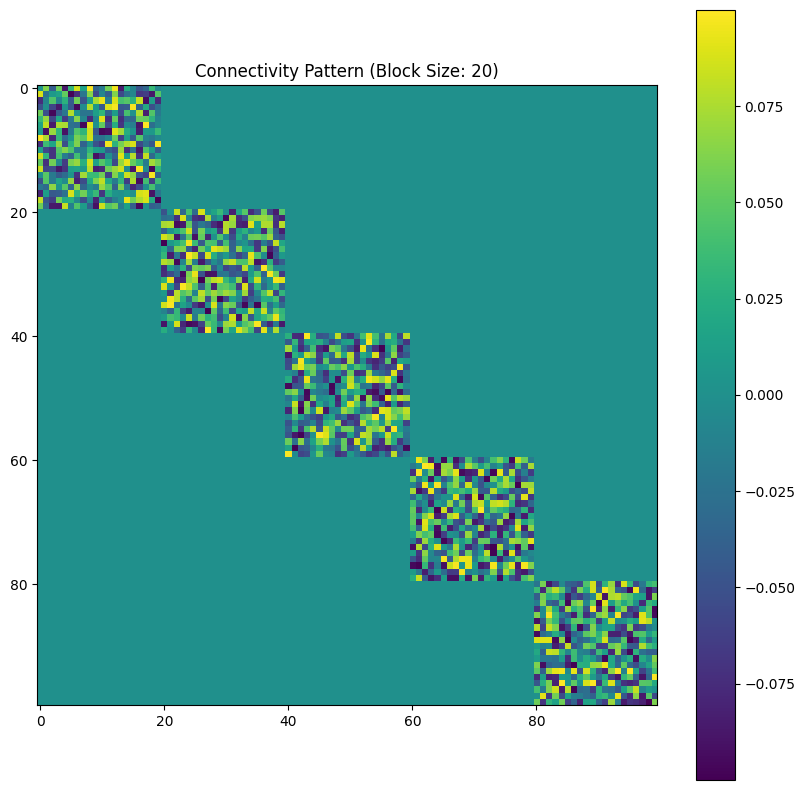

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

class MaskedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, block_size: int, bias: bool = True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)
        self.block_size = block_size
        self.register_buffer('mask', self.create_mask())

    def create_mask(self):
        mask = torch.zeros(self.weight.size())
        for i in range(0, self.out_features, self.block_size):
            j = i  # This ensures block diagonal structure
            mask[i:i+self.block_size, j:j+self.block_size] = 1
        return mask

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight * self.mask, self.bias)

    # def reset_parameters(self) -> None:
    #     super().reset_parameters()
    #     self.weight.data *= self.mask

    def visualize_connectivity(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.weight.data * self.mask, cmap='viridis')
        plt.title(f'Connectivity Pattern (Block Size: {self.block_size})')
        plt.colorbar()
        plt.show()

# Usage example:
layer = MaskedLinear(100, 100, block_size=20)
layer.visualize_connectivity()

10
10
torch.Size([100, 100])


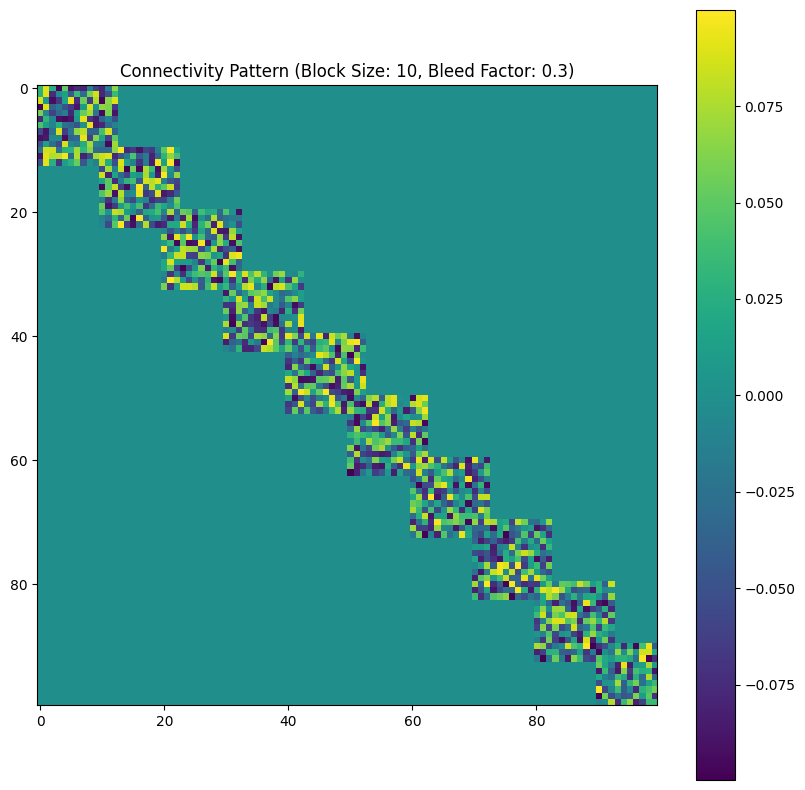

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

class MaskedLinear(nn.Linear):
    def __init__(self, in_features: int, out_features: int, block_size: int, bleed_factor: float = 0.0, bias: bool = True):
        super(MaskedLinear, self).__init__(in_features, out_features, bias)

        assert block_size * 2 < in_features, 'Block size must be less than half of the input features'
        assert block_size * 2 < out_features, 'Block size must be less than half of the output features'

        if in_features == out_features:
            self.block_size_i = block_size
            self.block_size_j = block_size
        elif in_features > out_features:
            self.block_size_i = math.ceil(in_features / (out_features // block_size))
            self.block_size_j = block_size
        else:
            self.block_size_i = block_size
            self.block_size_j = math.ceil(out_features / (in_features // block_size))

        print(self.block_size_i)
        print(self.block_size_j)

        self.block_size = block_size
        self.bleed_factor = bleed_factor  # New parameter to control bleeding
        self.register_buffer('mask', self.create_mask())

    def create_mask(self):
        mask = torch.zeros(self.weight.size())
        print(mask.shape)
        
        # Compute how much additional overlap is allowed based on the bleed factor
        bleed_size_i = int(self.block_size_i * self.bleed_factor)
        bleed_size_j = int(self.block_size_j * self.bleed_factor)

        i = 0
        for j in range(0, self.out_features, self.block_size_j):
            # Set the mask for the block and the bleed regions
            mask[j:j+self.block_size_j+bleed_size_j, i:i+self.block_size_i+bleed_size_i] = 1
            i = i + self.block_size_i
        
        # Clip the mask to the matrix size (in case of overflow due to bleeding)
        return mask[:self.out_features, :self.in_features]

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.linear(input, self.weight * self.mask, self.bias)


    def visualize_connectivity(self):
        plt.figure(figsize=(10, 10))
        
        # Get the weight data
        weights = self.weight.data * self.mask
        
        # Create a diverging colormap centered at zero
        vmax = max(abs(weights.max()), abs(weights.min()))
        vmin = -vmax
        
        # Plot with improved colormap and centered colorbar
        im = plt.imshow(weights, 
                       cmap='RdBu_r',  # Red-Blue diverging colormap
                       vmin=vmin,
                       vmax=vmax)
        
        plt.title(f'Connectivity Pattern (Block Size: {self.block_size}, Bleed Factor: {self.bleed_factor})')
        
        # Add colorbar with better formatting
        cbar = plt.colorbar(im)
        cbar.set_label('Weight Value')
        
        plt.xlabel('Input Features')
        plt.ylabel('Output Features')
        plt.show()

# Usage example:
layer = MaskedLinear(100, 100, block_size=10, bleed_factor=0.3)  # 30% bleed
layer.visualize_connectivity()


In [5]:
# Updated function without prints and assuming label data is passed directly
def is_confident(softmax_output, correct_labels):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check if the average of the correct class probabilities is above 90%
    avg_confidence = torch.mean(correct_class_probs)
    
    # Return a boolean indicating if average confidence is over 90%
    return avg_confidence, avg_confidence > 0.90

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
is_confident(softmax_output, correct_labels)


(tensor(0.7000), tensor(False))

In [10]:
import torch
import torch.nn.functional as F

def zero_correct_class_softmax(logits, correct_classes):
    # Set a large negative value for logits at the index of the correct class
    modified_logits = logits.clone()  # Clone to avoid modifying original logits in-place
    modified_logits[correct_classes == 1] = -1e9  # Use a very large negative value
    
    # Apply softmax to the modified logits
    softmax_output = F.softmax(modified_logits, dim=1)
    return softmax_output

# Example usage
logits = torch.tensor([[2.0, 1.5, 0.5], [0.5, 2.0, 1.0]], dtype=torch.float32)
correct_classes = torch.tensor([[0, 1, 0], [0, 0, 1]], dtype=torch.float32)  # One-hot encoded correct classes

result = zero_correct_class_softmax(logits, correct_classes)
print(torch.softmax(logits, dim=1))
print(result)


tensor([[0.5465, 0.3315, 0.1220],
        [0.1402, 0.6285, 0.2312]])
tensor([[0.8176, 0.0000, 0.1824],
        [0.1824, 0.8176, 0.0000]])


In [19]:
import torch

# Updated function without prints and assuming label data is passed directly
def is_confident(softmax_output, correct_labels, confidence_threshold):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check if all of the correct class probabilities are above the confidence threshold
    all_confident = torch.all(correct_class_probs > confidence_threshold)

    # Calculate the average confidence
    avg_confidence = torch.mean(correct_class_probs)

    # Return the confidence probabilities, average confidence, and whether all are above the threshold
    return avg_confidence.item(), all_confident.item()

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
confidence_threshold = 0.8
conf_probs, all_above_threshold = is_confident(softmax_output, correct_labels, confidence_threshold)
conf_probs, all_above_threshold

TypeError: '>' not supported between instances of 'Tensor' and 'str'

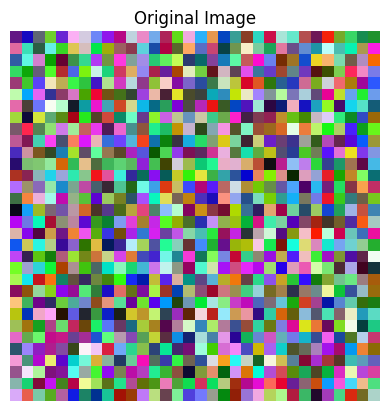

torch.Size([3072])

In [36]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define the patch size (width and height of the square patch)
patch_size = 4  # Example patch size

# Function to split image into patches and flatten them
def image_to_patches(img, patch_size):
    # img is a tensor of shape [C, H, W]
    # Get dimensions
    C, H, W = img.shape
    
    # Ensure the image height and width are divisible by the patch size
    assert H % patch_size == 0 and W % patch_size == 0, "Image dimensions must be divisible by patch size"
    
    # Calculate number of patches along each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size
    
    # Rearrange the image into patches and flatten each patch
    patches = img.unfold(1, patch_size, patch_size).unfold(2, patch_size, patch_size)
    # Now patches has shape [C, num_patches_h, num_patches_w, patch_size, patch_size]
    # Permute to bring patches together: [num_patches_h, num_patches_w, C, patch_size, patch_size]
    patches = patches.permute(1, 2, 0, 3, 4)
    # Reshape each patch to a flattened vector
    patches = patches.reshape(-1, C * patch_size * patch_size)
    return patches.flatten()

# Transform pipeline
transform = Compose([
    ToTensor(),
    Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    Lambda(lambda x: image_to_patches(x, patch_size=patch_size))
])

# Load an example CIFAR-like image (dummy small image for this example)
# Here we're generating a simple RGB image for demonstration
example_image = Image.fromarray((np.random.rand(32, 32, 3) * 255).astype(np.uint8))

# Apply transformation
transformed_image = transform(example_image)

# Display the original image and the transformed tensor shape
plt.imshow(example_image)
plt.title("Original Image")
plt.axis('off')
plt.show()

# Output some details about the transformed image
transformed_image_shape = transformed_image.shape
transformed_image_shape


In [16]:
import torch

# Function to check the percentage of correct softmax values above a given threshold
def percent_above_threshold(softmax_output, correct_labels, confidence_threshold):
    # Convert one-hot encoded labels to indices (get the correct class indices)
    correct_indices = torch.argmax(correct_labels, dim=1)  # [batch_size]
    
    # Gather the softmax probabilities of the correct class for each example in the batch
    correct_class_probs = softmax_output.gather(1, correct_indices.unsqueeze(1)).squeeze()

    # Check how many of the correct class probabilities are above the confidence threshold
    num_above_threshold = torch.sum(correct_class_probs > confidence_threshold).item()

    # Calculate the percentage of softmax values that are above the threshold
    percent_above = (num_above_threshold / correct_class_probs.size(0)) * 100

    # Return the percentage
    return percent_above

# Sample scenario

# Simulated softmax output (batch_size = 3, softmax_dim = 4)
softmax_output = torch.tensor([
    [0.1, 0.2, 0.6, 0.1],  # Example 1
    [0.05, 0.8, 0.1, 0.05],  # Example 2
    [0.7, 0.15, 0.1, 0.05]   # Example 3
])

# Simulated label data (batch_size = 3, one_hot_dim = 4)
correct_labels = torch.tensor([
    [0, 0, 1, 0],  # Correct class is index 2
    [0, 1, 0, 0],  # Correct class is index 1
    [1, 0, 0, 0]   # Correct class is index 0
])

# Test the function
confidence_threshold = 0.69
percent_above = percent_above_threshold(softmax_output, correct_labels, confidence_threshold)
percent_above

66.66666666666666

In [1]:
def mnist_to_patches(img, patch_size):
    """
    Convert an image into patches.

    Args:
        img (torch.Tensor): Input image tensor of shape [H, W] or [1, H, W]
        patch_size (int): Size of each square patch

    Returns:
        torch.Tensor: Flattened patches tensor
    """
    # Handle both single channel and no channel inputs
    if len(img.shape) == 2:
        # Add channel dimension if not present
        img = img.unsqueeze(0)

    # Get dimensions
    C, H, W = img.shape
    assert C == 1, "Image should be single channel"
    assert H % patch_size == 0 and W % patch_size == 0, f"Image dimensions ({H}, {W}) must be divisible by patch size {patch_size}"

    # Calculate number of patches along each dimension
    num_patches_h = H // patch_size
    num_patches_w = W // patch_size

    # Rearrange the image into patches
    patches = img.unfold(1, patch_size, patch_size).unfold(
        2, patch_size, patch_size)
    # Now patches has shape [1, num_patches_h, num_patches_w, patch_size, patch_size]

    # Remove channel dim and reshape to [num_patches_total, patch_size*patch_size]
    patches = patches.squeeze(0)
    patches = patches.reshape(-1, patch_size * patch_size)

    return patches.flatten()

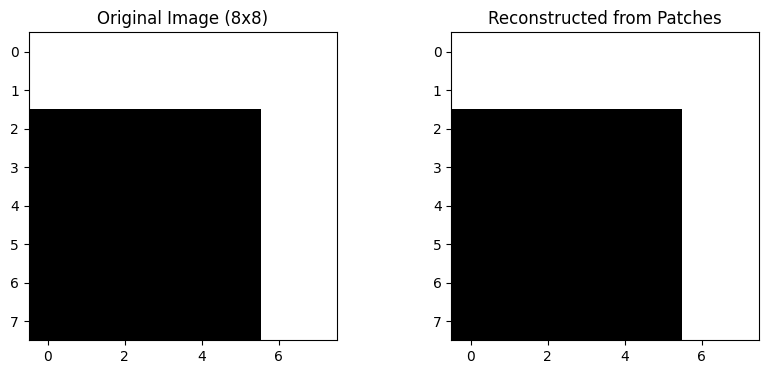

First few patch values: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
Patch shape: torch.Size([64])


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Create a simple test image (8x8 representing a digit-like pattern)
test_image = torch.zeros((8, 8))
# Make a simple "7" pattern
test_image[0:2, :] = 1.0  # Top horizontal line
test_image[:, 6:8] = 1.0  # Right vertical line

# Display original image
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(test_image, cmap='gray')
plt.title('Original Image (8x8)')

# Convert to patches
patch_size = 4  # We'll use 2x2 patches
patches = mnist_to_patches(test_image, patch_size)

# Verify the shape
expected_patches = (8 * 8) // (patch_size * patch_size) * patch_size * patch_size
assert len(patches) == 64, f"Expected 64 values, got {len(patches)}"

# Reshape patches for visualization
patch_grid = patches.reshape(-1, patch_size, patch_size)
reconstructed = torch.zeros_like(test_image)

# Reconstruct the image from patches
num_patches_per_row = test_image.shape[0] // patch_size
for i in range(len(patch_grid)):
    row = (i // num_patches_per_row) * patch_size
    col = (i % num_patches_per_row) * patch_size
    reconstructed[row:row+patch_size, col:col+patch_size] = patch_grid[i]

# Display reconstructed image
plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title('Reconstructed from Patches')

plt.show()

# Print patch values for inspection
print("First few patch values:", patches[:10])
print("Patch shape:", patches.shape)




In [ ]:
import torch
import torch.nn.functional as F

x = torch.ones(4,4)
print(x)
w = torch.nn.Linear(4,4, bias=False)
z = w(x)
w_inv = torch.linalg.inv(w.weight)
F.linear(z, w_inv)



tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])


tensor([[1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000]], grad_fn=<MmBackward0>)